<h2><center>Week 11 - Exercises class</center></h2>
<h3><center>Programming for Data Science 2024</center></h3>

Throughtout the notebook, the following resources are used:
- Fluent Python, 2nd Edition, by Luciano Ramalho
- [The Good Research Code Handbook](https://goodresearch.dev/), by Patrick Mineault
- [Research Software Engineering with Python](https://alan-turing-institute.github.io/rse-course/html/index.html), by Turing Research Engineering Group

### Decorators

As you've seen today, a part of *Defensive programming* is about modularizing programs. This includes practices of decomposition and abstraction, that we've seen last week.

One particular way of abstracting in Python are the so-called **decorators**. A decorator is a function or a class that wraps (or decorates) another function or method, taking it as an input. A decorator may perform some processing with the decorated function, and returns it or replaces it with another function or callable object.

In [ ]:
def target():
    print('running target()')

target = decorate(target)

# This is an equivalent syntax
@decorate
def target():
    print('running target()')

Now the target name is bound to whatever function is returned by *decorate(target)*, and this may be the initial function, or may be a different one. Usually it's the latter, whereby decorators change decorated functions, by defining a nested function and returning it instead of the original one. Here's an example of a decorator:

In [ ]:
def deco_name(func):  # the original function is passed as argument

    def inner(*args, **kwargs):  # a nested function is defined, and (keyword arguments) are passed to it
        result = func(*args, **kwargs)  # the original function is executed and the result stored
        print(f"Function {func.__name__} was executed.")
        return result  # results are returned by the inner function
    
    return inner  # the inner function is returned from the decorator

What does this decorator do?

In [ ]:
# Let's see

@deco_name
def sum_fun(a, b):
    return a + b

sum_fun(1, 2)

As seen, decorators often make use of inner functions, i.e. nested within other functions. The behavior of inner functions often depends on their **closure**. A closure is actually a function *f* with an extended scope that encompasses variables referenced in the body of *f* that are not global variables or local variables of f. Such variables must come from the local scope of an outer function that encompasses *f*. As in the example below for a function *averager* where the *series* variable is *nonlocal* and defined inside *make_averager*: 

<style>

figcaption {
  text-align: center;
  margin-top: 10px
}

.center {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;
}
</style>



<figure class="image">
  <img src="images/closure.png" style="width:50%" class="center">
  <figcaption >Example of the closure of the inner function averager. Image taken from Fluent Python, by Luciano Ramalho</figcaption>
</figure>

An excellent use of decorators is with *memoization* (or caching). The standard example here is that of the Fibonacci series. This series is defined in terms of previous terms recursively, such that $$F(n) = F(n-1)+F(n-2)\\ F(0)\equiv 0 \\ F(1)\equiv 1 \\ F=0,1,1,2,3,5,8,13,...$$

We can define it recursively also programmatically:

In [ ]:
# Fibonacci function

def fib(n: int) -> int:
    """Calculates the n-th term of the Fibonacci sequence"""
    if n < 2:
        return n
    return fib(n - 1) + fib(n - 2)

This is usually very slow to execute! Let's do a decorator to clock the running time of a function:

In [ ]:
# clock decorator

import time
import functools

def clock(func):
    @functools.wraps(func)  # this brings the __name__ and __doc__ attributes to the decorated function
    def inner(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        name = func.__name__
        arg_lst = [repr(arg) for arg in args]
        arg_lst.extend(f'{k}={v!r}' for k, v in kwargs.items())
        arg_str = ', '.join(arg_lst)
        print(f'[elapsed: {elapsed:0.8f}s] {name}({arg_str}) -> {repr(result)}')
        return result
    return inner

In [ ]:
# Fibonacci function (decorated)

@clock
def fib(n: int) -> int:
    if n < 2:
        return n
    return fib(n - 1) + fib(n - 2)

What do you expect the following output to be?

In [ ]:
fib(6)

Is the output what you expected? What is happening?

<details>
  <summary>Spoiler</summary>
  
  The function is recursive, so a single call actually internally calls the function around 2^n times! 
  
</details>

We can also see that as the numbers grow, the total required time increases exponentially. 12 seconds in this case!!

In [ ]:
fib(30)

The recursion called fib(1) 832,040 times, with a total of 2,692,537 calls!

A well known solution here is to *cache* previuos calls to the function, such that results are readily available. This can be easily achievable with a *functools* wrapper:

In [ ]:
# Cached fibonacci

@functools.cache
@clock
def fib(n: int) -> int:
    if n < 2:
        return n
    return fib(n - 1) + fib(n - 2)

In [ ]:
fib(30)

Now we just have 31 calls!!

Finally, we might want to parametrize our decorators. This is achievable by thinking that decorators are just wrappers that return a modified version of our original function. So what we want to achieve is something like this:
```python
func = deco(param)(func)
```

We can see an example of how to parametrize our *clock* decorator.

In [ ]:
# Parametrized clock decorator

def clock(fmt='[elapsed: {elapsed:0.8f}s] {name}({arg_str}) -> {result}'):   # we have an additional layer here where the parametrization happens
    def decorate(func):
        @functools.wraps(func)
        def inner(*args, **kwargs):
            start = time.time()
            _result = func(*args, **kwargs)
            elapsed = time.time() - start
            name = func.__name__
            arg_lst = [repr(arg) for arg in args]
            arg_lst.extend(f'{k}={v!r}' for k, v in kwargs.items())
            arg_str = ', '.join(arg_lst)
            result = repr(_result)
            print(fmt.format(**locals()))
            return _result
        return inner
    return decorate

With standard format:

In [ ]:
@clock()
def snooze(sec):
    time.sleep(sec)

for _ in range(3):
    snooze(0.1)

With a different format:

In [ ]:
@clock(fmt="Function: {name}; Elapsed: {elapsed:0.3f}s")
def snooze(sec):
    time.sleep(sec)

for _ in range(3):
    snooze(0.1)

And so on. This is very powerful when you have possibly many parametrizations to test or to greatly enhance the functionality of an existing decorator.

A final note. You see from the above function that the definition is quite cumbersome. A better approach may be to define the decorator using a class. Here's an example with the usual *clock* decorator:

In [ ]:
class Clock:  

    def __init__(self, fmt='[elapsed: {elapsed:0.8f}s] {name}({arg_str}) -> {result}'):  # the argument is defined in the initialization
        self.fmt = fmt

    def __call__(self, func):  
        def inner(*args, **kwargs):
            start = time.time()
            _result = func(*args, **kwargs)
            elapsed = time.time() - start
            name = func.__name__
            arg_lst = [repr(arg) for arg in args]
            arg_lst.extend(f'{k}={v!r}' for k, v in kwargs.items())
            arg_str = ', '.join(arg_lst)
            result = repr(_result)
            print(self.fmt.format(**locals()))
            return _result
        return inner

We see that the same result is achieved, with somewhat less clutter:

In [ ]:
@Clock(fmt="Function: {name}; Elapsed: {elapsed:0.3f}s")
def snooze(sec):
    time.sleep(sec)

for _ in range(3):
    snooze(0.1)

### Testing

As you've seen in class, testing is a fundamental component of project development. There is even an approach - Test-Driven Development (TDD) - that gives testing a primary importance by always writing and commiting tests before the related production code. Apart from this "extreme" approach, it's generally a good idea to:
- Write your tests simultaneously with your production code
- Allow your tests to affect the design of your production code
- Ensure that your tests cover (i) the core function of the software and (ii) any input sanity checking

Automated testing is one of the most powerful techniques to make code robust. Testing allows to maintain a level of certainty when things work, and immediately know when they don't, e.g. after a  refactoring. Of course, there are also cases where testing alone doesn't suffice:
- Testing won’t correct a buggy code
- Testing will tell you were the bugs are if - and only if - the test cases cover the scenarios that cause the bugs or occur.

Let's revit our example of the Fibonacci function in this context.

We typically want to test for:
- "Normal" cases, i.e. the inputs that shouldn't create problems
- "Boundary" cases, i.e. cases that are on the edge of the calculation, or when there are indices
- Empty arrays
- explicit failures do indeed happen and exceptions are raised

A simple approach is to test with assertions:

In [2]:
from fib import fib

assert fib(0) == 0
assert fib(1) == 1
assert fib(2) == 2

AssertionError: 

We see that we have an error on the first assertion and we can modify the function accordingly.

We can also make the whole procedure more automatic with atesting framework. In class you've seen how to use the *unittest* library, but actually *pytest* is the most popular Python library for testing. It also has a *raises* method to help chacking whether exceptions are raised.

In [6]:
# This runs the terminal
!pytest test_fib.py

============================= test session starts ==============================
platform darwin -- Python 3.11.7, pytest-8.2.0, pluggy-1.5.0
rootdir: /Users/cusinatr/Documents/Phd_work/AdvPy24/W11
plugins: anyio-4.2.0
collected 3 items                                                              

test_fib.py ...                                                          [100%]

============================== 3 passed in 0.01s ===============================


**In-class exercise: Diffusion model in 1D**

Taken from [Research Software Engineering with Python](https://alan-turing-institute.github.io/rse-course/html/module05_testing_your_code/05_03_energy_example.html)

You want to create a one-dimensional diffusion model. (Could be a gas of particles, or a bunch of crowded people in a corridor, or animals in a valley habitat…)
- Agents are on a 1d axis
- Agents do not want to be where there are other agents
- This is represented as an ‘energy’: the higher the energy, the more unhappy the agents.

Implementation:
- Given a vector *n* of positive integers, and of arbitrary length
- Compute the energy $E(n) = \sum_{i}n_i(n_i - 1)$

Example:

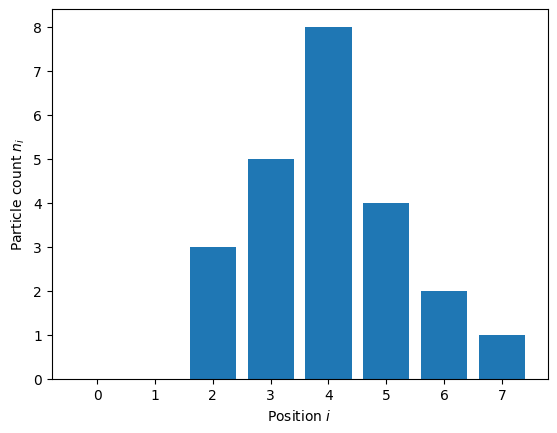

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

density = np.array([0, 0, 3, 5, 8, 4, 2, 1])
fig, ax = plt.subplots()
ax.bar(np.arange(len(density)), density)
ax.xrange = [-0.5, len(density) - 0.5]
ax.set_ylabel("Particle count $n_i$")
ax.set_xlabel("Position $i$")
plt.show()

Here, the total energy due to position 2 is 3(3 - 1), and due to column 7 is 1(1 - 1). We need to sum these to get the total energy.

**Task 1**: code the energy function.

In [ ]:
def energy(density, coeff=1.0):
    """Energy associated with the diffusion model

    Parameters
    ----------

    density: array of positive integers
        Number of particles at each position i in the array
    coeff: float
        Diffusion coefficient.
    """
    # implementation goes here

**Task 2**: create two scripts, one called *model.py* and another called *test_model.py*. Put the *energy* function just created in the former and the following in the latter, completing the test function:

In [ ]:
from .model import energy


def test_energy():
    pass
    # Test something

**NB**: try to iteratively improve the function as you come up with test cases.

In [16]:
!pytest test_model.py

============================= test session starts ==============================
platform darwin -- Python 3.11.7, pytest-8.2.0, pluggy-1.5.0
rootdir: /Users/cusinatr/Documents/Phd_work/AdvPy24/W11
plugins: anyio-4.2.0
collected 6 items                                                              

test_model.py ......                                                     [100%]

============================== 6 passed in 0.09s ===============================
